In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
import warnings
import seaborn as sns
#import pygmmis
from my_gmm import my_GMM, estimate_MI_single_posterior_sample, consistent, bootstrap_multiprocessing
#from multiprocess import set_start_method
# https://pythonspeed.com/articles/python-multiprocessing/
#set_start_method("fork") # 'fork' seems to get deadlocked, 'spawn' is a bit slower but works
#from multiprocess import Pool
from functools import partial
from sklearn.feature_selection import mutual_info_regression
import gc
import time
from scipy.stats import multivariate_normal
from scipy.stats import chi2 as chisquare

from matplotlib.patches import Ellipse
import pandas as pd

from sklearn.utils import check_random_state
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import pygmmis

In [2]:
def draw_ellipse(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha, **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha, label=label if count==0 else "")
    ax.legend(fontsize=20, frameon=False)
        
def plot_covariance(means, covariances, weights, means_fitted, covariances_fitted, weights_fitted, N, ax=None):
    ax = ax or plt.gca()
    ax.set_xlim((-4, 4))
    ax.set_ylim((-1.5, 4))
    
    w_factor = 0.5 # just for the plot
    count=0
    for mean, covariance, weight in zip(means, covariances, weights):
        draw_ellipse(mean, covariance, weight, ax=ax, alpha=w_factor, fill=False, color='blue', linewidth=3, label='Ground truth', count=count)
        count += 1

    count=0
    for mean_fitted, covariance_fitted, weight_fitted in zip(means_fitted, covariances_fitted, weights_fitted):
        draw_ellipse(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='red', linewidth=3, label='Fitted', count=count)
        count += 1

In [3]:
# here we define a custom model for a fixed gmm with known parameters
class FixedParMixture_:
    """ A model to estimate gaussian mixture with fixed parameters matrix. 
        This is only needed to estimate its log-likelihood, not to sample from it
        Note this is only for a 1D GMM, as in n_features=1! 
    """
    def __init__(self, n_components, mean, cov, weight):
        self.n_components = n_components
        self.mean = mean
        self.cov = cov
        self.w = weight

    
    def estimate_prob(self, X):
        marginal = 0
        for i in range(self.n_components):
            mu = self.mean[i]
            sigma = self.cov[i]
            w = self.w[i]
            marginal += w*multivariate_normal.pdf(x=np.array([X]).T, mean=np.array([mu]), cov=np.array([sigma]))         
        return marginal
        
    
    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
            
        This is taken from the sklearn source code
        """

        return np.log(self.estimate_prob(X))

def marginal_loglike_(gmm, points, n_components, i):
    # i = 0 is x
    # i = 1 is y
    ll = FixedParMixture_(n_components, gmm.means_[:, i], gmm.covariances_[:, i, i], gmm.weights_).score_samples(points[:, i])
    return ll


In [4]:
# three different models, chosen based on the number of components
n_components = 3

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)

In [5]:
def calc_entropy(n_comp, best_w, best_m, best_c):
    best_fitted_GMM = my_GMM(n_components=n_comp, weights=best_w, means=best_m, covariances=best_c, random_state=0)
    integral_samples = best_fitted_GMM.sample(1e6)[0]

    log_values = best_fitted_GMM.score_samples(integral_samples)
    best_mean_value = log_values.mean()
    best_var_value = (log_values**2).mean()
    best_var_value = best_var_value - best_mean_value**2
    best_mean_value *= ds_size
    best_var_value *=  ds_size
    best_stddev_value = np.sqrt(best_var_value)
    
    return best_mean_value, best_stddev_value

In [6]:
true_MI_analytical = estimate_MI_single_posterior_sample(gmm_true, MC_samples=1e5)
true_MI_analytical

0.13212342606785435

### Procedure: we loop over k components. Do 4-fold CV over N=1e4 samples, doing 10 inits each time. Pick the highest validation loss. Plot val loss as a function of k. Also check for optimality. Then select best model, and calculate MI for both best model and one with one more component.

In [64]:
n_inits = 1
n_datasets = 9
C = 1/np.sqrt(1)
ds_size = int(1e4)
N = n_datasets*ds_size
tol = 1e-6
reg_covar = 1e-6
n_components_loop = 4 # we break, so no need to loop for too long
val_losses = np.zeros(( n_components_loop, 2 ))
goodness_flags = np.zeros(n_components_loop)
best_ws, best_ms, best_cs, best_ps = [], [], [], []

X_all = np.zeros((n_datasets, ds_size, 2))

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for i in range(n_datasets):
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+9500)
    X_all[i] = gmm_true.sample(ds_size)[0]
    
        
for k in range(n_components_loop):
    #best_validation_score = -np.inf
    if k == 0:
        print(f'{k+1} component')
    else:
        print(f'{k+1} components')
        
    val_scores_mus_devs = np.zeros(( int(n_datasets*n_inits), 2 ))
    val_scores_mus_devs_x = np.zeros(( int(n_datasets*n_inits), 2 ))
    val_scores_mus_devs_y = np.zeros(( int(n_datasets*n_inits), 2 ))

    current_ws = np.zeros(( int(n_datasets*n_inits), k+1 ))
    current_ms = np.zeros(( int(n_datasets*n_inits), k+1, 2 ))
    current_cs = np.zeros(( int(n_datasets*n_inits), k+1, 2, 2))
    current_ps = np.zeros(( int(n_datasets*n_inits), k+1, 2, 2 ))

    for dataset in range(n_datasets):

        X_training = X_all[dataset].reshape(ds_size, 2)
        print(gmm_true.score_samples(X_training).sum())
        
        print(marginal_loglike_(gmm_true, X_training, 3, 0).sum())
        print(marginal_loglike_(gmm_true, X_training, 3, 1).sum())
        

        X_validation = X_all[np.arange(len(X_all))!=dataset].reshape(n_datasets-1, ds_size, 2)#X_all[dataset*ds_size:(dataset+1)*ds_size]#X_all[mask]

        for r, init in enumerate(range(n_inits)):
            validation_scores = []
            validation_scores_x, validation_scores_y = [], []
            fitted_gmm = GMM(n_components=k+1, reg_covar=reg_covar, 
                             init_params='kmeans', tol=tol, max_iter=10000, 
                             random_state=r+dataset).fit(X_training)
            # evaluate each fitted model on validation data
            for j in range(n_datasets-1):
                val_score = fitted_gmm.score_samples(X_validation[j].reshape(ds_size, 2)).sum()
                validation_scores.append(np.copy(val_score))
                
                marginal_x = marginal_loglike_(fitted_gmm, X_validation[j].reshape(ds_size, 2), k+1, 0)
                validation_scores_x.append(marginal_x.sum())
                
                marginal_y = marginal_loglike_(fitted_gmm, X_validation[j].reshape(ds_size, 2), k+1, 1)
                validation_scores_y.append(marginal_y.sum())

            #validation_scores.append( fitted_gmm.score_samples(X_training).sum() )
            
            val_score_mu, val_score_std = np.mean(validation_scores), np.std(validation_scores)
            val_scores_mus_devs[dataset*n_inits+r] = val_score_mu, val_score_std
            
            val_score_mu_x, val_score_std_x = np.mean(validation_scores_x), np.std(validation_scores_x)
            val_scores_mus_devs_x[dataset*n_inits+r] = val_score_mu_x, val_score_std_x
            val_score_mu_y, val_score_std_y = np.mean(validation_scores_y), np.std(validation_scores_y)
            val_scores_mus_devs_y[dataset*n_inits+r] = val_score_mu_y, val_score_std_y
            
            current_ws[dataset*n_inits+r] = np.copy(fitted_gmm.weights_)
            current_ms[dataset*n_inits+r] = np.copy(fitted_gmm.means_)
            current_cs[dataset*n_inits+r] = np.copy(fitted_gmm.covariances_)
            current_ps[dataset*n_inits+r] = np.copy(fitted_gmm.precisions_)
            
            #print(val_score_mu)
            
            # check if current validation loss is highest
            #if val_score_mu > best_validation_score:
            #    #print('Found higher validation score')
            #    best_validation_score = val_score_mu
            #    best_validation_score_std = val_score_std
            #    best_validation_score_x, best_validation_score_std_x = np.mean(validation_scores_x), np.std(validation_scores_x)
            #    best_validation_score_y, best_validation_score_std_y = np.mean(validation_scores_y), np.std(validation_scores_y)
            #    
            #    # save current model
            #    best_w, best_m, best_c = np.copy(fitted_gmm.weights_), np.copy(fitted_gmm.means_), np.copy(fitted_gmm.covariances_)
            #    best_p = np.copy(fitted_gmm.precisions_)
                
    val_scores_mus = val_scores_mus_devs[:, 0]
    best_index = np.argsort(val_scores_mus)[len(val_scores_mus)//2]
    #best_index = np.argmax(val_scores_mus)

    best_w, best_m, best_c, best_p = current_ws[best_index], current_ms[best_index], current_cs[best_index], current_ps[best_index]    
    best_validation_score = val_scores_mus[best_index]
    best_validation_score_std = val_scores_mus_devs[best_index, 1]
    best_validation_score_x, best_validation_score_std_x = val_scores_mus_devs_x[best_index]
    best_validation_score_y, best_validation_score_std_y = val_scores_mus_devs_y[best_index]
    
    print(f'val_score = {best_validation_score}', best_index)

    # check that best model is good enough for the current component, including marginals
    entropy_mu, entropy_std = calc_entropy(k+1, best_w, best_m, best_c)
    entropy_mu_x, entropy_std_x = calc_entropy(k+1, best_w, best_m[:, :1], best_c[:, :1, :1])
    entropy_mu_y, entropy_std_y = calc_entropy(k+1, best_w, best_m[:, 1:2], best_c[:, 1:2, 1:2])

    print(f'entropy {entropy_mu}, {entropy_mu_x}, {entropy_mu_y}')
    optim_flag = consistent(best_validation_score, entropy_mu, best_validation_score_std, entropy_std, C=C)
    optim_flag_x = consistent(best_validation_score_x, entropy_mu_x, best_validation_score_std_x, entropy_std_x, C=C)
    optim_flag_y = consistent(best_validation_score_y, entropy_mu_y, best_validation_score_std_y, entropy_std_y, C=C)
    print(optim_flag, optim_flag_x, optim_flag_y)
    
    
    # need to save current val_score mu and std, and whether this was a good model or not
    val_losses[k] = np.array([best_validation_score, best_validation_score_std])
    goodness_flags[k] = optim_flag and optim_flag_x and optim_flag_y
    
    # save also best model for current number of components
    best_ws.append(best_w)
    best_ms.append(best_m)
    best_cs.append(best_c)
    best_ps.append(best_p)
    
    
    # check if we need to break, since we reached convergence
    # skip first component, as we have nothing to compare it against
    if k > 0:
        validation_converged = consistent(val_losses[k][0], val_losses[k-1][0], val_losses[k][1], val_losses[k-1][1])
        #print(validation_converged, goodness_flags[k], goodness_flags[k-1])
        convergence_reached = goodness_flags[k] and goodness_flags[k-1] and validation_converged
        print(bool(convergence_reached))
        if convergence_reached:
            print(f'Reached convergence at {k} components')
            break
            
    print('=====')

1 component
-22555.960435233123
-13558.04047065242
-10300.601792248533
-22747.312807142083
-13676.592955483307
-10262.927906464942
-22629.452632384247
-13503.109286542443
-10453.34038974702
-22750.118556370122
-13571.833722004256
-10410.206995275308
-22484.996080870453
-13512.690142996906
-10270.791904765483
-22568.552701424935
-13585.883087477425
-10306.096461621166
-22699.720078355418
-13669.58091317521
-10278.459279108649
-22585.235453942267
-13615.658243990374
-10375.162108579909
-22649.758369448355
-13685.9139134189
-10289.74967480278
val_score = -24155.467526680506 2
entropy -24150.845139979785, -13880.76976699305, -10744.479213109673
True False False
=====
2 components
-22555.960435233123
-13558.04047065242
-10300.601792248533
-22747.312807142083
-13676.592955483307
-10262.927906464942
-22629.452632384247
-13503.109286542443
-10453.34038974702
-22750.118556370122
-13571.833722004256
-10410.206995275308
-22484.996080870453
-13512.690142996906
-10270.791904765483
-22568.5527014249

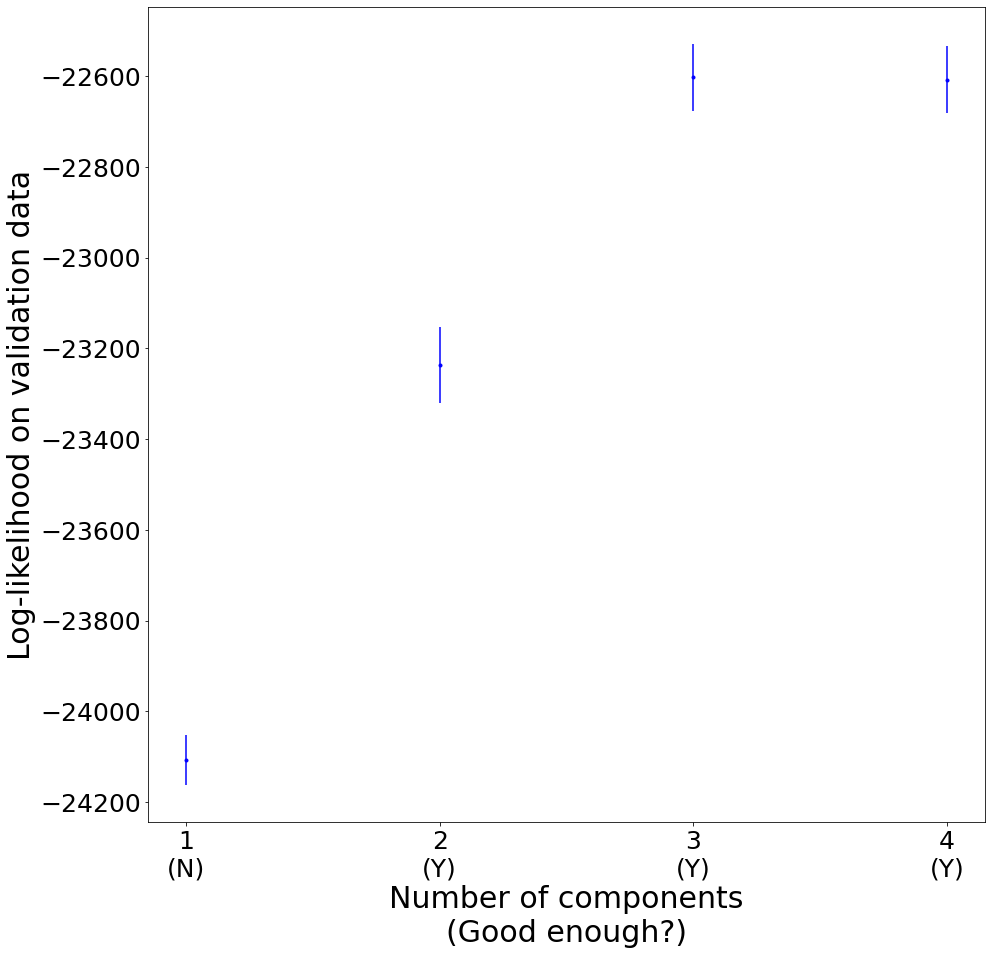

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.errorbar(np.arange(len(best_ws))+1, val_losses[:len(best_ws), 0], val_losses[:len(best_ws), 1], fmt='.', color='b')

ax.set_xticks(np.arange(len(best_ws))+1)
ax.set_xticklabels(['1\n(N)', '2\n(Y)', '3\n(Y)', '4\n(Y)'])

ax.set_xlabel('Number of components\n(Good enough?)', fontsize=30)
ax.set_ylabel('Log-likelihood on validation data', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

In [42]:
goodness_flags

array([1., 0., 0., 1.])

In [43]:
# now calculate MI

In [55]:
X_all_flat = np.reshape(X_all, (-1, 2))
bootstrap_samples = 50
index_best = len(best_w)-2 # index is the length of all models, -1 since we stop at the second to last, -1 since it's an index
MI_estimates = np.zeros(bootstrap_samples)
MC_samples = 1e5

In [68]:
# first calculate the MI of the best-fit model
gmm_best = my_GMM(n_components=index_best+1, weights=best_ws[index_best], means=best_ms[index_best],
                  covariances=best_cs[index_best], random_state=0)
single_MI = estimate_MI_single_posterior_sample(gmm_best, MC_samples=MC_samples)
print(single_MI)
    
gmm_refit = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
          weights_init=best_ws[index_best], means_init=best_ms[index_best], 
          precisions_init=best_ps[index_best]).fit(X_all_flat)

single_MI = estimate_MI_single_posterior_sample(gmm_refit, MC_samples=MC_samples)
print(single_MI)
    
    
for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
              weights_init=best_ws[index_best], means_init=best_ms[index_best], 
              precisions_init=best_ps[index_best]).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.1335574494663991
0.13309556729482147
0.13294895810419835 0.002251557846691932


In [69]:
true_MI_analytical

0.13212342606785435

In [ ]:
index_best = len(best_w)-1
MI_estimates = np.zeros(bootstrap_samples)

# first calculate the MI of the best-fit model
gmm_best = my_GMM(n_components=index_best+1, weights=best_ws[index_best], means=best_ms[index_best],
                  covariances=best_cs[index_best], random_state=0)
single_MI = estimate_MI_single_posterior_sample(gmm_best, MC_samples=MC_samples)
print(single_MI)
    
gmm_refit = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
          weights_init=best_ws[index_best], means_init=best_ms[index_best], 
          precisions_init=best_ps[index_best]).fit(X_all_flat)

single_MI = estimate_MI_single_posterior_sample(gmm_refit, MC_samples=MC_samples)
print(single_MI)
    
    
for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
              weights_init=best_ws[index_best], means_init=best_ms[index_best], 
              precisions_init=best_ps[index_best]).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.1335574494663991
0.1335465149566876


In [15]:
goodness_flags

array([1., 1., 1., 1., 0., 0., 0.])

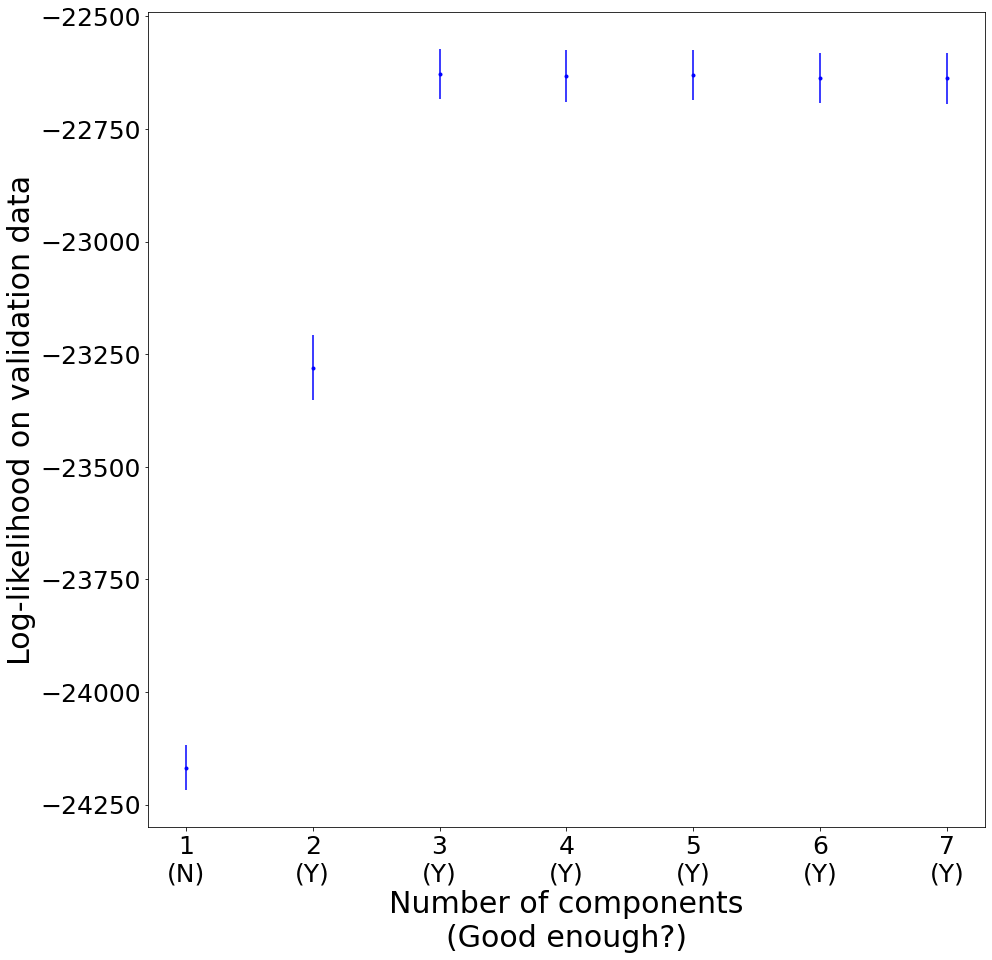

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.errorbar(np.arange(n_components_loop)+1, val_losses[:, 0], val_losses[:, 1], fmt='.', color='b')

ax.set_xticks(np.arange(n_components_loop)+1)
ax.set_xticklabels(['1\n(N)', '2\n(Y)', '3\n(Y)', '4\n(Y)', '5\n(Y)', '6\n(Y)', '7\n(Y)'])

ax.set_xlabel('Number of components\n(Good enough?)', fontsize=30)
ax.set_ylabel('Log-likelihood on validation data', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

In [13]:
consistent(val_losses[3][0], val_losses[2][0], val_losses[3][1], val_losses[2][1])

True

In [10]:
# now calculate MI

In [10]:
X_all_flat = np.reshape(X_all, (-1, 2))
bootstrap_samples = 50
index_best = 2
MI_estimates = np.zeros(bootstrap_samples)
MC_samples = 1e5

# first calculate the MI of the best-fit model
gmm_best = my_GMM(n_components=index_best+1, weights=best_ws[index_best], means=best_ms[index_best],
                  covariances=best_cs[index_best], random_state=0)
single_MI = estimate_MI_single_posterior_sample(gmm_best, MC_samples=MC_samples)
print(single_MI)
    
for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=index_best+1, n_init=2, tol=tol, max_iter=1000, 
              weights_init=best_ws[index_best], means_init=best_ms[index_best], 
              precisions_init=best_ps[index_best]).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.12946225141257525
0.13201668717655007 0.0029206827792536277


In [11]:
true_MI_analytical

0.13240196036094962

In [12]:
index_best = 3
MI_estimates = np.zeros(bootstrap_samples)

# first calculate the MI of the best-fit model
gmm_best = my_GMM(n_components=index_best+1, weights=best_ws[index_best], means=best_ms[index_best],
                  covariances=best_cs[index_best], random_state=0)
single_MI = estimate_MI_single_posterior_sample(gmm_best, MC_samples=MC_samples)
print(single_MI)
    
for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
              weights_init=best_ws[index_best], means_init=best_ms[index_best], 
              precisions_init=best_ps[index_best]).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.12724024230855294
0.13233515844171817 0.002501061014414741


In [ ]:
0.13201668717655007 0.0029206827792536277

In [15]:
0.13201668717655007-true_MI_analytical

-0.0017744669561260418